# Catastrophic forgetting example over 4 tasks

In [19]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os
import numpy as np
import random

Adapted from Original Pytorch github https://github.com/pytorch/examples/blob/main/mnist/main.py 

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0.0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        total_loss += loss.item()

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()


        loss.backward()
        optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    # Calculate and return the average loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy = 100.*correct / len(train_loader.dataset)
    return accuracy, average_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return accuracy, test_loss

def train_and_test(args, model, device, train_loader, test_loader, optimizer, scheduler, title = ""):
    train_losses = []  # Store training losses
    test_accuracies = []  # Store test accuracies
    test_losses = [] 
    train_accuracies = [] 

    for epoch in range(1, args.epochs + 1):
        train_accuracy, train_loss = train(args, model, device, train_loader, optimizer, epoch)
        test_accuracy, test_loss = test(model, device, test_loader)
        scheduler.step()

        
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

            # Print training loss and test accuracy during each epoch
        print(f'Epoch {epoch}/{args.epochs}: Training Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
        
    # Plot loss and accuracy after all epochs
    plot_loss_and_accuracy(train_accuracies, train_losses, test_accuracies, test_losses, title)

def save_model_state_dict(model_state_dict, filename, overwrite=True):
    models_folder = "models"
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)

    file_path = os.path.join(models_folder, filename)

    if os.path.exists(file_path) and not overwrite:
        user_input = input(f"The file '{filename}' already exists. Do you want to overwrite it? (yes/no): ")
        if user_input.lower() != 'yes':
            print("Model not saved.")
            return
    torch.save(model_state_dict, file_path)
    print(f"Model state dict saved to: {file_path}")
def plot_loss_and_accuracy(train_accuracies, train_losses, test_accuracies, test_losses, title=""):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    # Plot Training Loss and Accuracy
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(train_accuracies, label='Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title(f'{title} - Training Data')
    ax1.legend()

    # Plot Testing Loss and Accuracy
    ax2.plot(test_losses, label='Testing Loss')
    ax2.plot(test_accuracies, label='Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{title} - Testing Data')
    ax2.legend()

    # Calculate % change in accuracy between train and test
    train_accuracies = np.array(train_accuracies)
    test_accuracies = np.array(test_accuracies)
    percentage_change = np.abs((train_accuracies - test_accuracies) / train_accuracies * 100)

    # Plot % change
    ax3.plot(percentage_change, label='% Change')
    ax3.set_xlabel('Epoch')
    ax3.set_title(f'{title} - % Change in Accuracy')
    ax3.legend()

    plt.tight_layout()
    plt.show()

def plot_loss_and_accuracy_simple(train_accuracies, train_losses, test_accuracies, test_losses, title = ""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Training Loss and Accuracy
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(train_accuracies, label='Training Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title(f'{title} - training data')
    ax1.legend()

    # Plot Testing Loss and Accuracy
    ax2.plot(test_losses, label='Testing Loss')
    ax2.plot(test_accuracies, label='Testing Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{title} - testing data')
    ax2.legend()

    
def get_data_loaders(dataset, train_size, test_size, train_kwargs, test_kwargs):
    train_set, test_set = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_set, **train_kwargs)
    test_loader = DataLoader(test_set, **test_kwargs)
    return train_loader, test_loader

def get_scenario_labels():
    # Define scenarios with different sets of labels
    scenarios = [
        [5, 6, 7, 8, 9, 1],
        [6, 7, 8, 9, 1, 2],
        [7, 8, 9, 1, 2, 3],
        [8, 9, 1, 2, 3, 4]
    ]

    # Randomly select a scenario
    selected_scenario = random.choice(scenarios)

    return selected_scenario

def run_scenario(args, optimizer_taskN, scheduler_taskN, model, device, train_kwargs, test_kwargs, scenario, title_prefix="Task", transform=None):
    mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

    if args.test_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:1000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)

    scenario_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in scenario]

    train_size = int(0.8 * len(scenario_indices))
    test_size = len(scenario_indices) - train_size

    train_loader, test_loader = get_data_loaders(
        Subset(mnist_dataset, scenario_indices), train_size, test_size, train_kwargs, test_kwargs
    )

    # reuse task 1 optimizer and scheduler
    optimizer = optimizer_taskN
    scheduler = scheduler_taskN

    train_and_test(args, model, device, train_loader, test_loader, optimizer, scheduler, title=f"{title_prefix}: ")
    model_state_dict = model.state_dict()
    save_model_state_dict(model_state_dict, f"mnist_cnn_{title_prefix.lower()}.pt")
    return f"mnist_cnn_{title_prefix.lower()}.pt"



In [21]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
parser.add_argument('--test_reduced', action='store_true', default=False,
                        help='For Saving the current Model')


args, unknown = parser.parse_known_args()
use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()
    
torch.manual_seed(args.seed)

if use_cuda:
        device = torch.device("cuda")
elif use_mps:
        device = torch.device("mps")
else:
        device = torch.device("cpu")

Define task-1 model

Train Epoch: 1 [0/24476 (0%)]	Loss: 1.806019
Train Epoch: 1 [640/24476 (3%)]	Loss: 0.303721
Train Epoch: 1 [1280/24476 (5%)]	Loss: 0.523371
Train Epoch: 1 [1920/24476 (8%)]	Loss: 0.134271
Train Epoch: 1 [2560/24476 (10%)]	Loss: 0.149967
Train Epoch: 1 [3200/24476 (13%)]	Loss: 0.061632
Train Epoch: 1 [3840/24476 (16%)]	Loss: 0.159291
Train Epoch: 1 [4480/24476 (18%)]	Loss: 0.024213
Train Epoch: 1 [5120/24476 (21%)]	Loss: 0.145728
Train Epoch: 1 [5760/24476 (23%)]	Loss: 0.038265
Train Epoch: 1 [6400/24476 (26%)]	Loss: 0.200634
Train Epoch: 1 [7040/24476 (29%)]	Loss: 0.236083
Train Epoch: 1 [7680/24476 (31%)]	Loss: 0.042015
Train Epoch: 1 [8320/24476 (34%)]	Loss: 0.117560
Train Epoch: 1 [8960/24476 (37%)]	Loss: 0.056570
Train Epoch: 1 [9600/24476 (39%)]	Loss: 0.052564
Train Epoch: 1 [10240/24476 (42%)]	Loss: 0.039215
Train Epoch: 1 [10880/24476 (44%)]	Loss: 0.177474
Train Epoch: 1 [11520/24476 (47%)]	Loss: 0.121357
Train Epoch: 1 [12160/24476 (50%)]	Loss: 0.043812
Train Epoch: 1 [12800/24

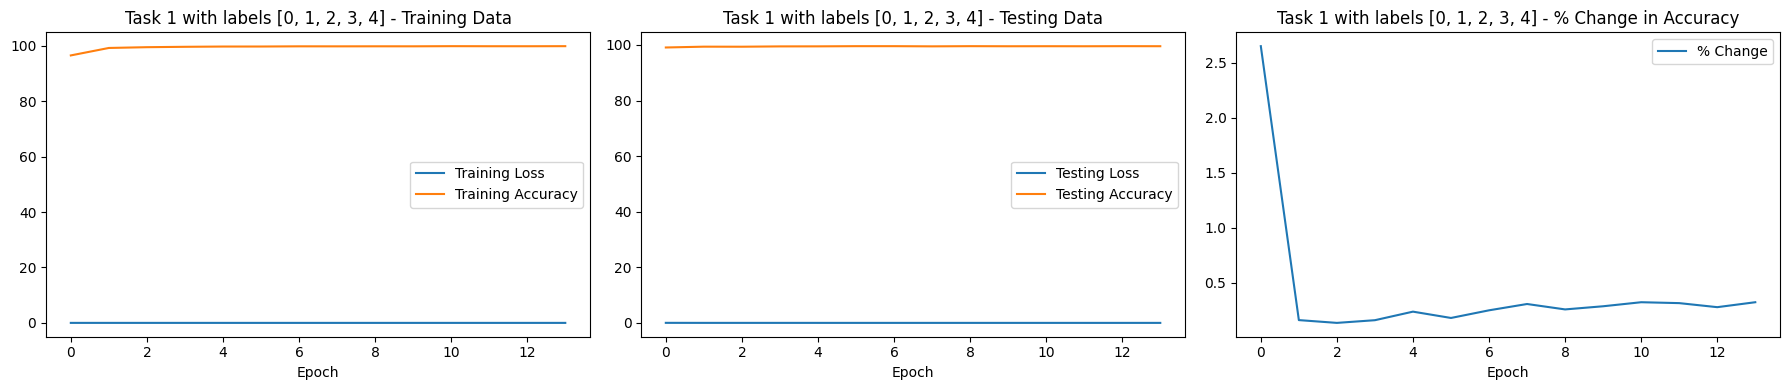

Model state dict saved to: models/mnist_cnn_task1.pt


In [22]:
# Set up common configurations
train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if 'cuda' in str(device):
    cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)

if args.test_reduced:
        sampled_indices = torch.randperm(len(mnist_dataset))[:1000]
        mnist_dataset = Subset(mnist_dataset, sampled_indices)

# Define task 1 labeling
task1_classes = [0, 1, 2, 3, 4]
task1_indices = [i for i, (_, label) in enumerate(mnist_dataset) if label in task1_classes]
task1_dataset = Subset(mnist_dataset, task1_indices)

train_size_task1 = int(0.8 * len(task1_indices))
test_size_task1 = len(task1_indices) - train_size_task1

train_loader_task1, test_loader_task1 = get_data_loaders(task1_dataset, train_size_task1, test_size_task1,
                                                             train_kwargs, test_kwargs)
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
train_and_test(args, model, device, train_loader_task1, test_loader_task1, optimizer, scheduler,title=f"Task 1 with labels {task1_classes}")
model_state_dict_task1 = model.state_dict()
save_model_state_dict(model_state_dict_task1, "mnist_cnn_task1.pt")


In [23]:
test(model, device, test_loader_task1)


Test set: Average loss: 0.0175, Accuracy: 6091/6120 (100%)



(99.52614379084967, 0.01752720303784788)

# Testing on 4 different tasks 


Train Epoch: 1 [0/29516 (0%)]	Loss: 0.000024
Train Epoch: 1 [640/29516 (2%)]	Loss: 0.001015
Train Epoch: 1 [1280/29516 (4%)]	Loss: 0.022464
Train Epoch: 1 [1920/29516 (6%)]	Loss: 0.001305
Train Epoch: 1 [2560/29516 (9%)]	Loss: 0.000036
Train Epoch: 1 [3200/29516 (11%)]	Loss: 0.000023
Train Epoch: 1 [3840/29516 (13%)]	Loss: 0.000057
Train Epoch: 1 [4480/29516 (15%)]	Loss: 0.011685
Train Epoch: 1 [5120/29516 (17%)]	Loss: 0.000665
Train Epoch: 1 [5760/29516 (19%)]	Loss: 0.000134
Train Epoch: 1 [6400/29516 (22%)]	Loss: 0.080056
Train Epoch: 1 [7040/29516 (24%)]	Loss: 0.000057
Train Epoch: 1 [7680/29516 (26%)]	Loss: 0.000224
Train Epoch: 1 [8320/29516 (28%)]	Loss: 0.001066
Train Epoch: 1 [8960/29516 (30%)]	Loss: 0.000251
Train Epoch: 1 [9600/29516 (32%)]	Loss: 0.000010
Train Epoch: 1 [10240/29516 (35%)]	Loss: 0.002073
Train Epoch: 1 [10880/29516 (37%)]	Loss: 0.001504
Train Epoch: 1 [11520/29516 (39%)]	Loss: 0.000289
Train Epoch: 1 [12160/29516 (41%)]	Loss: 0.000766
Train Epoch: 1 [12800/295

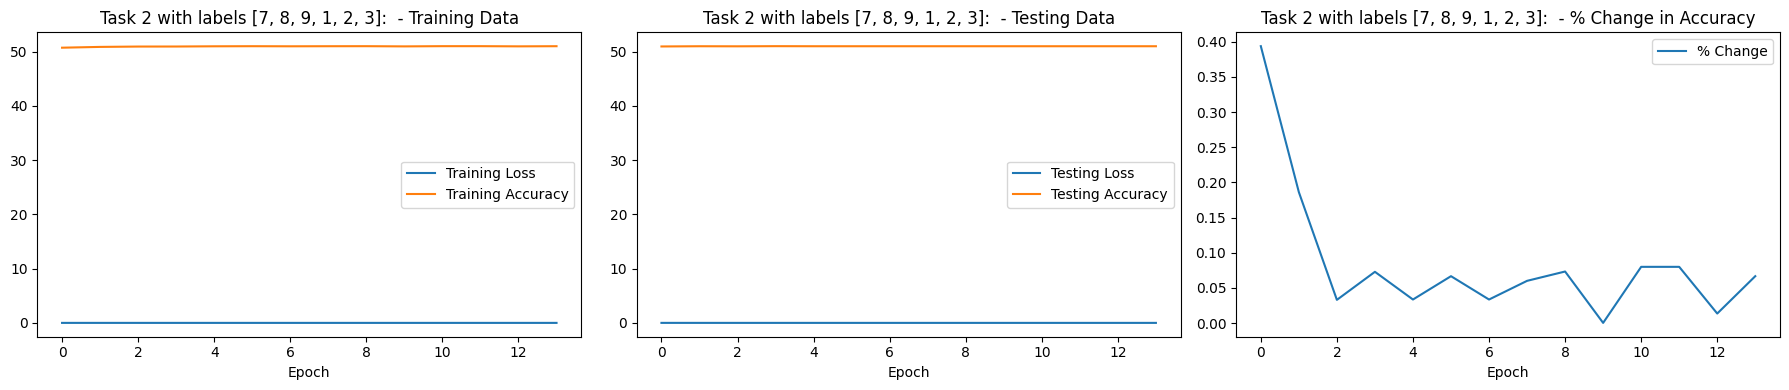

Model state dict saved to: models/mnist_cnn_task 2 with labels [7, 8, 9, 1, 2, 3].pt
Train Epoch: 1 [0/29178 (0%)]	Loss: 0.036907
Train Epoch: 1 [640/29178 (2%)]	Loss: 0.000402
Train Epoch: 1 [1280/29178 (4%)]	Loss: 0.099984
Train Epoch: 1 [1920/29178 (7%)]	Loss: 0.006748
Train Epoch: 1 [2560/29178 (9%)]	Loss: 0.036170
Train Epoch: 1 [3200/29178 (11%)]	Loss: 0.015639
Train Epoch: 1 [3840/29178 (13%)]	Loss: 0.058160
Train Epoch: 1 [4480/29178 (15%)]	Loss: 0.117299
Train Epoch: 1 [5120/29178 (18%)]	Loss: 0.080515
Train Epoch: 1 [5760/29178 (20%)]	Loss: 0.000257
Train Epoch: 1 [6400/29178 (22%)]	Loss: 0.007507
Train Epoch: 1 [7040/29178 (24%)]	Loss: 0.012370
Train Epoch: 1 [7680/29178 (26%)]	Loss: 0.127034
Train Epoch: 1 [8320/29178 (29%)]	Loss: 0.000062
Train Epoch: 1 [8960/29178 (31%)]	Loss: 0.061328
Train Epoch: 1 [9600/29178 (33%)]	Loss: 0.026619
Train Epoch: 1 [10240/29178 (35%)]	Loss: 0.000502
Train Epoch: 1 [10880/29178 (37%)]	Loss: 0.046604
Train Epoch: 1 [11520/29178 (39%)]	Loss:

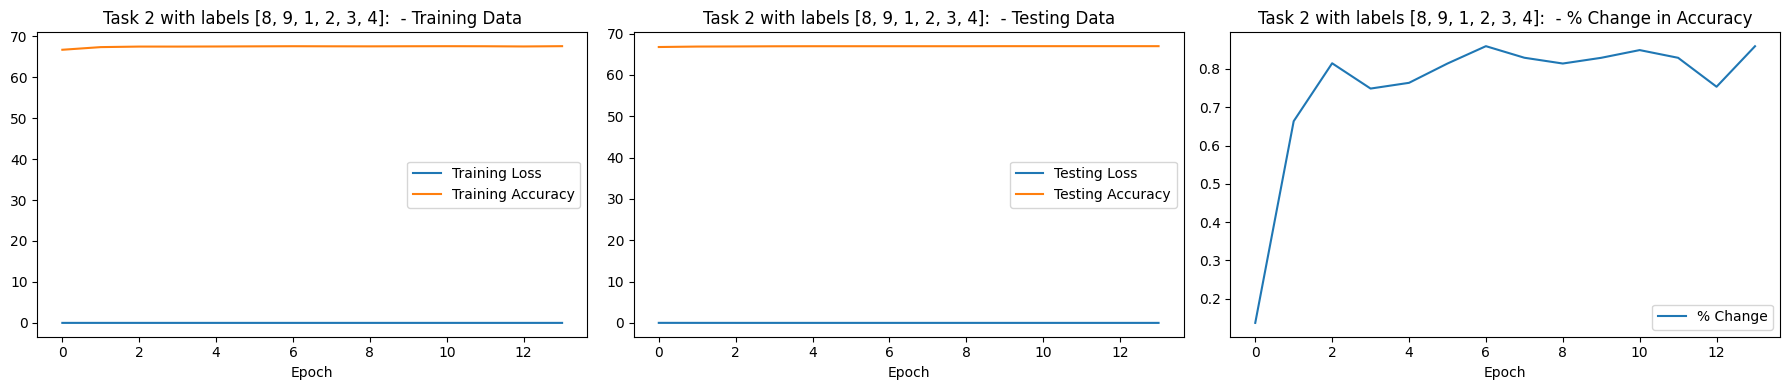

Model state dict saved to: models/mnist_cnn_task 2 with labels [8, 9, 1, 2, 3, 4].pt
Train Epoch: 1 [0/29516 (0%)]	Loss: 0.000014
Train Epoch: 1 [640/29516 (2%)]	Loss: 0.002201
Train Epoch: 1 [1280/29516 (4%)]	Loss: 0.000719
Train Epoch: 1 [1920/29516 (6%)]	Loss: 0.000002
Train Epoch: 1 [2560/29516 (9%)]	Loss: 0.003058
Train Epoch: 1 [3200/29516 (11%)]	Loss: 0.000000
Train Epoch: 1 [3840/29516 (13%)]	Loss: 0.000002
Train Epoch: 1 [4480/29516 (15%)]	Loss: 0.001092
Train Epoch: 1 [5120/29516 (17%)]	Loss: 0.000057
Train Epoch: 1 [5760/29516 (19%)]	Loss: 0.000028
Train Epoch: 1 [6400/29516 (22%)]	Loss: 0.000001
Train Epoch: 1 [7040/29516 (24%)]	Loss: 0.000001
Train Epoch: 1 [7680/29516 (26%)]	Loss: 0.000002
Train Epoch: 1 [8320/29516 (28%)]	Loss: 0.000000
Train Epoch: 1 [8960/29516 (30%)]	Loss: 0.000037
Train Epoch: 1 [9600/29516 (32%)]	Loss: 0.000466
Train Epoch: 1 [10240/29516 (35%)]	Loss: 0.000155
Train Epoch: 1 [10880/29516 (37%)]	Loss: 0.004850
Train Epoch: 1 [11520/29516 (39%)]	Loss:

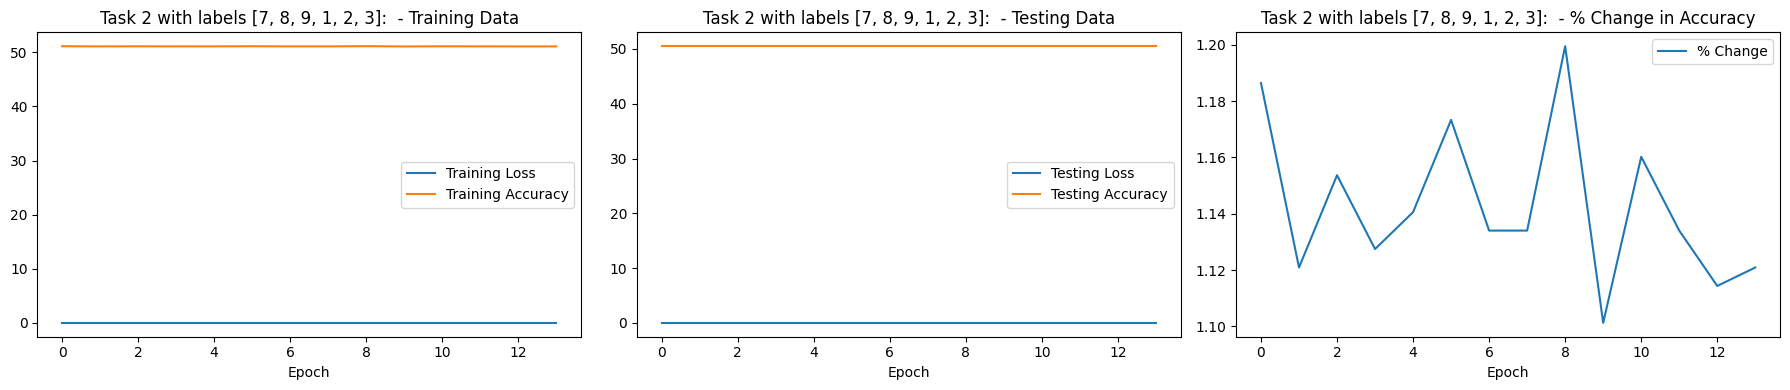

Model state dict saved to: models/mnist_cnn_task 2 with labels [7, 8, 9, 1, 2, 3].pt
Train Epoch: 1 [0/29178 (0%)]	Loss: 0.009438
Train Epoch: 1 [640/29178 (2%)]	Loss: 0.059551
Train Epoch: 1 [1280/29178 (4%)]	Loss: 0.000004
Train Epoch: 1 [1920/29178 (7%)]	Loss: 0.001441
Train Epoch: 1 [2560/29178 (9%)]	Loss: 0.053013
Train Epoch: 1 [3200/29178 (11%)]	Loss: 0.000971
Train Epoch: 1 [3840/29178 (13%)]	Loss: 0.000821
Train Epoch: 1 [4480/29178 (15%)]	Loss: 0.000046
Train Epoch: 1 [5120/29178 (18%)]	Loss: 0.001417
Train Epoch: 1 [5760/29178 (20%)]	Loss: 0.000063
Train Epoch: 1 [6400/29178 (22%)]	Loss: 0.000179
Train Epoch: 1 [7040/29178 (24%)]	Loss: 0.059023
Train Epoch: 1 [7680/29178 (26%)]	Loss: 0.002512
Train Epoch: 1 [8320/29178 (29%)]	Loss: 0.002646
Train Epoch: 1 [8960/29178 (31%)]	Loss: 0.003851
Train Epoch: 1 [9600/29178 (33%)]	Loss: 0.002677
Train Epoch: 1 [10240/29178 (35%)]	Loss: 0.015184
Train Epoch: 1 [10880/29178 (37%)]	Loss: 0.001083
Train Epoch: 1 [11520/29178 (39%)]	Loss:

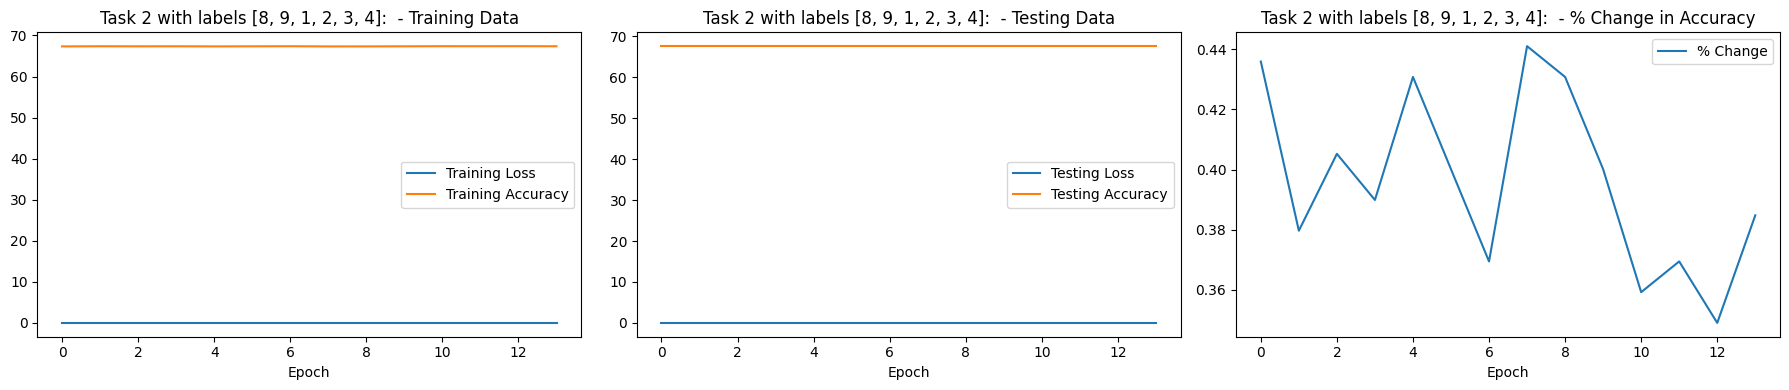

Model state dict saved to: models/mnist_cnn_task 2 with labels [8, 9, 1, 2, 3, 4].pt


In [25]:
model_taskN = Net().to(device)
# load the weights from model trained on task 1
model_taskN.load_state_dict(model_state_dict_task1.copy()) 
optimizer_taskN = optim.Adadelta(model_taskN.parameters(), lr=args.lr)
scheduler_taskN = StepLR(optimizer_taskN, step_size=1, gamma=args.gamma)

for i in range(4):
    # Get scenario labels for each iteration
    scenario_labels_i = get_scenario_labels()
    run_scenario(args,optimizer_taskN,scheduler_taskN, model_taskN, device, train_kwargs, test_kwargs, scenario_labels_i, transform=transform, title_prefix=f"Task 2 with labels {scenario_labels_i}")
